🧬 GENEALOGICAL RELATIONSHIP EXTRACTOR
This tool extracts family relationships from Wikipedia articles

Enter the name of a person to analyze: Albert Einstein
Extracting genealogical relationships for: Albert Einstein
Step 1: Fetching Wikipedia data...
✓ Found Wikipedia page: Albert Einstein
✓ Relevant sections: Marriages, relationships and children

Step 2: Chunking text...
✓ Created 3 text chunks

Step 3: Finding relevant chunks using embeddings...
✓ Selected 3 most relevant chunks

Step 4: Extracting relationships with Gemini...

EXTRACTED RELATIONSHIPS:

📊 Subject: Albert Einstein

💑 Spouses (2):
   1. Mileva Marić
   2. Elsa Löwenthal

👶 Children (3):
   1. Lieserl
   2. Hans Albert
   3. Eduard

Step 5: Creating family tree visualization...


/tmp/ipython-input-3349867899.py:324: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


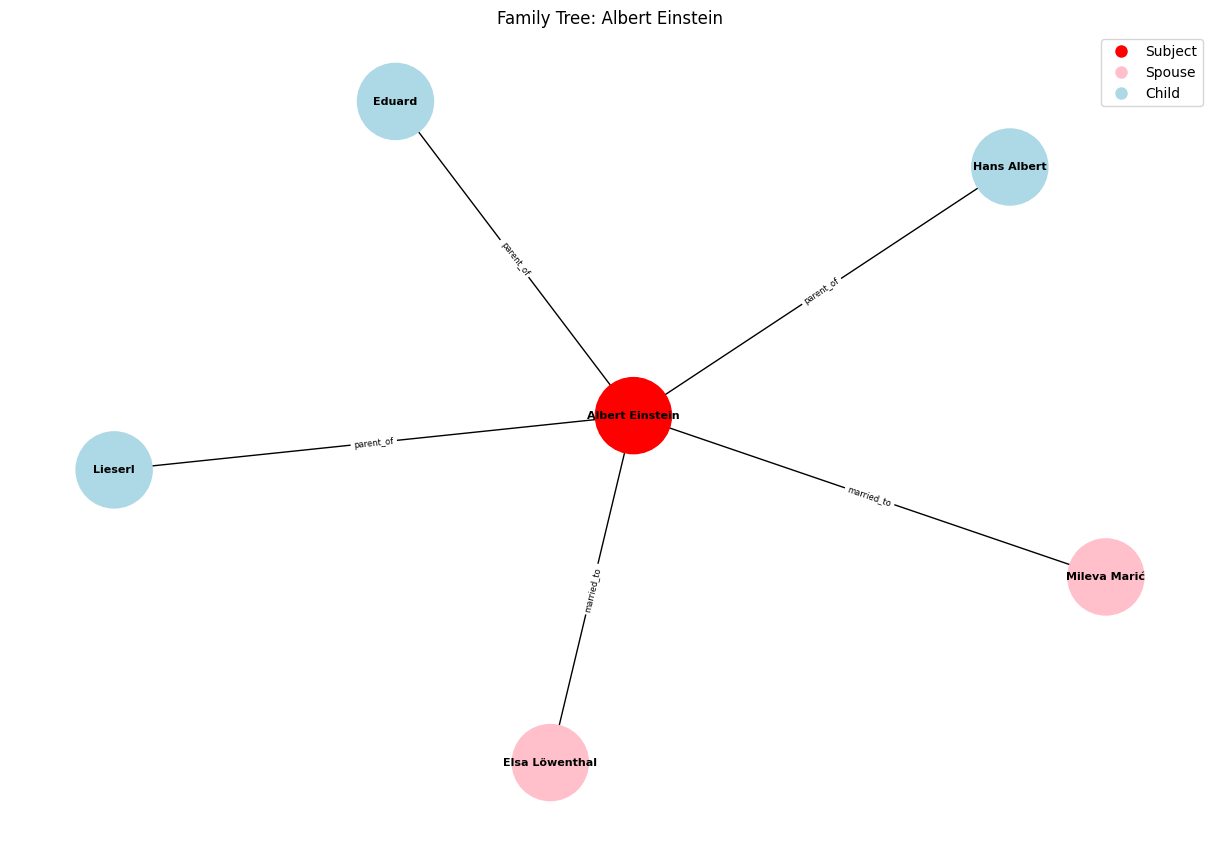


✅ Analysis complete! Check the visualization above.
🔗 Source: https://en.wikipedia.org/wiki/Albert_Einstein


In [3]:
#!/usr/bin/env python3
"""
Genealogical Relationship Extractor for Wikipedia Articles
Extracts spouse and child relationships from Wikipedia articles about people
"""

# Install required packages
# !pip install wikipedia-api google-generativeai networkx matplotlib numpy

import wikipediaapi
import google.generativeai as genai
from google.generativeai import embed_content
import numpy as np
import re
from typing import List, Tuple, Dict, Optional
import networkx as nx
import matplotlib.pyplot as plt
import time

# Configure Gemini API - Replace with your API key
GEMINI_API_KEY = "API key"
genai.configure(api_key=GEMINI_API_KEY)

def get_wikipedia_data(name: str, lang: str = "en") -> Dict:
    """
    Fetch Wikipedia page data and extract sections likely to contain genealogical info
    """
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent="GenealogyExtractor/1.0 (https://yourdomain.com)"
    )

    page = wiki.page(name)
    if not page.exists():
        return {"found": False, "query": name, "error": "Page not found"}

    # Keywords for sections likely to contain family/genealogical information
    genealogy_keywords = [
        "personal life",
        "family",
        "marriage",
        "children",
        "early life",
        "biography",
        "life",
        "relationships",
        "spouse",
        "wife",
        "husband",
        "descendants",
        "ancestry"
    ]

    def _find_section_by_keywords(sections: List[wikipediaapi.WikipediaPageSection],
                                 keywords: List[str]) -> List[wikipediaapi.WikipediaPageSection]:
        """Find sections containing genealogical keywords"""
        found_sections = []
        lower_keywords = [k.lower() for k in keywords]

        for section in sections:
            title_lower = (section.title or "").lower()
            if any(k in title_lower for k in lower_keywords):
                found_sections.append(section)
            # Recursively search subsections
            found_sections.extend(_find_section_by_keywords(section.sections, lower_keywords))

        return found_sections

    relevant_sections = _find_section_by_keywords(page.sections, genealogy_keywords)

    # Combine text from all relevant sections
    genealogy_text = ""
    section_titles = []

    for section in relevant_sections:
        if section.text.strip():
            genealogy_text += f"\n\n{section.title}:\n{section.text}"
            section_titles.append(section.title)

    # If no specific sections found, use summary and first part of main text
    if not genealogy_text.strip():
        genealogy_text = page.summary + "\n\n" + page.text[:2000]
        section_titles = ["Summary and Introduction"]

    return {
        "found": True,
        "title": page.title,
        "url": page.fullurl,
        "summary": page.summary,
        "full_text": page.text,
        "genealogy_sections": section_titles,
        "genealogy_text": genealogy_text.strip(),
    }

def chunk_text_intelligently(text: str, max_chunk_size: int = 1000) -> List[str]:
    """
    Split text into chunks while preserving sentence and paragraph boundaries
    """
    # First split by paragraphs
    paragraphs = text.split('\n\n')
    chunks = []
    current_chunk = ""

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        # If adding this paragraph would exceed chunk size
        if len(current_chunk) + len(para) > max_chunk_size and current_chunk:
            chunks.append(current_chunk.strip())
            current_chunk = para
        else:
            if current_chunk:
                current_chunk += "\n\n" + para
            else:
                current_chunk = para

    # Add the last chunk
    if current_chunk.strip():
        chunks.append(current_chunk.strip())

    return chunks

def find_relevant_chunks_for_relationships(chunks: List[str], top_k: int = 3) -> List[Tuple[str, float]]:
    """
    Find chunks most relevant to genealogical relationships using embeddings
    """
    try:
        # Keywords that indicate genealogical relationships
        relationship_query = """
        family relationships marriage spouse wife husband children son daughter
        married divorced widowed offspring descendants lineage genealogy ancestry
        """

        # Get embeddings for all chunks
        chunk_embeddings = []
        for chunk in chunks:
            try:
                emb = embed_content(model="models/embedding-001", content=chunk)["embedding"]
                chunk_embeddings.append(np.array(emb))
            except Exception as e:
                print(f"Error getting embedding for chunk: {e}")
                chunk_embeddings.append(np.zeros(768))  # Default embedding size

        # Get embedding for relationship query
        query_emb = embed_content(model="models/embedding-001", content=relationship_query)["embedding"]
        query_emb = np.array(query_emb)

        # Calculate similarities
        similarities = []
        for i, chunk_emb in enumerate(chunk_embeddings):
            if np.linalg.norm(chunk_emb) > 0 and np.linalg.norm(query_emb) > 0:
                similarity = np.dot(query_emb, chunk_emb) / (np.linalg.norm(query_emb) * np.linalg.norm(chunk_emb))
            else:
                similarity = 0
            similarities.append((chunks[i], similarity))

        # Sort by similarity and return top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

    except Exception as e:
        print(f"Error in similarity search: {e}")
        # Fallback: return chunks that contain relationship keywords
        relevant_chunks = []
        keywords = ["married", "wife", "husband", "spouse", "children", "son", "daughter", "family"]
        for chunk in chunks:
            score = sum(1 for keyword in keywords if keyword.lower() in chunk.lower())
            if score > 0:
                relevant_chunks.append((chunk, score))

        relevant_chunks.sort(key=lambda x: x[1], reverse=True)
        return relevant_chunks[:top_k]

def extract_relationships_with_gemini(subject_name: str, relevant_text: str) -> Dict[str, List[str]]:
    """
    Use Gemini to extract spouse and child relationships from the text
    """
    prompt = f"""
You are a genealogical relationship extractor. Extract family relationships from the given text about {subject_name}.

IMPORTANT INSTRUCTIONS:
1. Extract ONLY relationships explicitly mentioned in the provided text
2. Do NOT make assumptions or add information not in the text
3. Return relationships in the exact format specified below
4. If a relationship is not mentioned, return an empty list

Text about {subject_name}:
{relevant_text}

Extract the following relationships for {subject_name}:

1. SPOUSES: Who was {subject_name} married to? Include all spouses mentioned.
2. CHILDREN: Who are the children of {subject_name}? Include all children mentioned.

Return your answer in this exact JSON format:
{{
    "spouses": ["spouse1", "spouse2", ...],
    "children": ["child1", "child2", ...]
}}

Only include names that are explicitly mentioned in the text as spouses or children of {subject_name}.
Do not include any explanatory text, just the JSON.
"""

    try:
        model = genai.GenerativeModel('gemini-1.5-flash')
        response = model.generate_content(prompt)

        # Parse the JSON response
        response_text = response.text.strip()

        # Extract JSON from response (remove markdown formatting if present)
        if "```json" in response_text:
            response_text = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            response_text = response_text.split("```")[1].strip()

        # Try to parse as JSON
        import json
        try:
            relationships = json.loads(response_text)
            return {
                "spouses": relationships.get("spouses", []),
                "children": relationships.get("children", [])
            }
        except json.JSONDecodeError:
            # Fallback parsing if JSON fails
            print(f"JSON parsing failed, trying manual extraction from: {response_text}")
            return parse_relationships_manually(response_text)

    except Exception as e:
        print(f"Gemini API error: {e}")
        return {"spouses": [], "children": []}

def parse_relationships_manually(text: str) -> Dict[str, List[str]]:
    """
    Fallback manual parsing if JSON parsing fails
    """
    relationships = {"spouses": [], "children": []}

    lines = text.split('\n')
    current_category = None

    for line in lines:
        line = line.strip()
        if 'spouse' in line.lower():
            current_category = 'spouses'
        elif 'child' in line.lower():
            current_category = 'children'
        elif line.startswith('"') and current_category:
            # Extract name from quoted string
            name = line.strip('"').strip(',')
            if name and name not in relationships[current_category]:
                relationships[current_category].append(name)

    return relationships

def create_family_tree_graph(subject_name: str, relationships: Dict[str, List[str]]) -> nx.Graph:
    """
    Create a network graph of family relationships
    """
    G = nx.Graph()

    # Add the main subject
    G.add_node(subject_name, node_type='subject')

    # Add spouses
    for spouse in relationships['spouses']:
        G.add_node(spouse, node_type='spouse')
        G.add_edge(subject_name, spouse, relationship='married_to')

    # Add children
    for child in relationships['children']:
        G.add_node(child, node_type='child')
        G.add_edge(subject_name, child, relationship='parent_of')

    return G

def visualize_family_tree(G: nx.Graph, subject_name: str):
    """
    Visualize the family tree
    """
    plt.figure(figsize=(12, 8))

    # Define colors for different node types
    node_colors = []
    for node in G.nodes():
        node_type = G.nodes[node].get('node_type', 'unknown')
        if node_type == 'subject':
            node_colors.append('red')
        elif node_type == 'spouse':
            node_colors.append('pink')
        elif node_type == 'child':
            node_colors.append('lightblue')
        else:
            node_colors.append('gray')

    # Create layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color=node_colors,
            node_size=3000, font_size=8, font_weight='bold')

    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

    plt.title(f"Family Tree: {subject_name}")

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                  markersize=10, label='Subject'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink',
                  markersize=10, label='Spouse'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                  markersize=10, label='Child')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

def extract_genealogical_relationships(person_name: str, max_iterations: int = 3):
    """
    Main function to extract genealogical relationships from Wikipedia
    """
    print(f"Extracting genealogical relationships for: {person_name}")
    print("=" * 50)

    # Step 1: Get Wikipedia data
    print("Step 1: Fetching Wikipedia data...")
    wiki_data = get_wikipedia_data(person_name)

    if not wiki_data.get("found"):
        print(f"Error: {wiki_data.get('error', 'Unknown error')}")
        return None

    print(f"✓ Found Wikipedia page: {wiki_data['title']}")
    print(f"✓ Relevant sections: {', '.join(wiki_data['genealogy_sections'])}")

    # Step 2: Chunk the text
    print("\nStep 2: Chunking text...")
    chunks = chunk_text_intelligently(wiki_data['genealogy_text'])
    print(f"✓ Created {len(chunks)} text chunks")

    # Step 3: Find most relevant chunks using embeddings
    print("\nStep 3: Finding relevant chunks using embeddings...")
    try:
        relevant_chunks = find_relevant_chunks_for_relationships(chunks, top_k=3)
        print(f"✓ Selected {len(relevant_chunks)} most relevant chunks")

        # Combine top chunks
        combined_text = "\n\n---\n\n".join([chunk for chunk, score in relevant_chunks])
    except Exception as e:
        print(f"Warning: Embedding search failed ({e}), using full genealogy text")
        combined_text = wiki_data['genealogy_text']

    # Step 4: Extract relationships using Gemini
    print("\nStep 4: Extracting relationships with Gemini...")
    relationships = extract_relationships_with_gemini(wiki_data['title'], combined_text)

    # Step 5: Display results
    print("\n" + "=" * 50)
    print("EXTRACTED RELATIONSHIPS:")
    print("=" * 50)

    print(f"\n📊 Subject: {wiki_data['title']}")

    if relationships['spouses']:
        print(f"\n💑 Spouses ({len(relationships['spouses'])}):")
        for i, spouse in enumerate(relationships['spouses'], 1):
            print(f"   {i}. {spouse}")
    else:
        print("\n💑 Spouses: None found")

    if relationships['children']:
        print(f"\n👶 Children ({len(relationships['children'])}):")
        for i, child in enumerate(relationships['children'], 1):
            print(f"   {i}. {child}")
    else:
        print("\n👶 Children: None found")

    # Step 6: Create and visualize family tree
    print("\nStep 5: Creating family tree visualization...")
    family_graph = create_family_tree_graph(wiki_data['title'], relationships)
    visualize_family_tree(family_graph, wiki_data['title'])

    return {
        'subject': wiki_data['title'],
        'relationships': relationships,
        'graph': family_graph,
        'source_url': wiki_data['url']
    }

# Example usage and testing
if __name__ == "__main__":
    # Test with famous historical figures
    test_subjects = [
        "Charles II of England",
        "Albert Einstein",
        "Queen Victoria",
        "Napoleon Bonaparte"
    ]

    print("🧬 GENEALOGICAL RELATIONSHIP EXTRACTOR")
    print("=" * 60)
    print("This tool extracts family relationships from Wikipedia articles")
    print("=" * 60)

    # You can uncomment and run these examples:

    # Example 1: Extract relationships for Charles II
    # result = extract_genealogical_relationships("Charles II of England")

    # Example 2: Extract relationships for Einstein
    # result = extract_genealogical_relationships("Albert Einstein")

    # Interactive mode
    person_name = input("\nEnter the name of a person to analyze: ").strip()
    if person_name:
        result = extract_genealogical_relationships(person_name)

        if result:
            print(f"\n✅ Analysis complete! Check the visualization above.")
            print(f"🔗 Source: {result['source_url']}")
    else:
        print("Please provide a person's name to analyze.")

In [2]:
!pip install wikipedia-api google-generativeai networkx matplotlib numpy


  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=251b1338a6d33bd80277b1b8d785745189acd7bd76b6f223ed0470d62c528a11
  Stored in directory: /root/.cache/pip/wheels/33/3c/79/b36253689d838af4a0539782853ac3cc38a83a6591ad570dde
Successfully built wikipedia-api


🧬 COMPREHENSIVE GENEALOGICAL RELATIONSHIP EXTRACTOR
Extracts multi-generational family relationships from Wikipedia
Format: 'Person child of Parent' and 'Person spouse of Spouse'

Enter the name of a person to analyze: Albert Einstein
🧬 COMPREHENSIVE GENEALOGY EXTRACTOR
Analyzing: Albert Einstein
Step 1: Fetching Wikipedia data...
✅ Found Wikipedia page: Albert Einstein
✅ Relevant sections: Childhood, youth and education, Marriages, relationships and children, Death
✅ Text length: 13794 characters

Step 2: Chunking text for analysis...
✅ Created 9 text chunks

Step 3: Finding most relevant chunks...
✅ Selected top 5 relevant chunks

Step 4: Extracting all relationships with Gemini...
   (This may take a moment for comprehensive analysis...)
✅ Extracted 8 relationship statements

Step 5: Processing and categorizing relationships...

COMPREHENSIVE GENEALOGICAL RELATIONSHIPS

🎯 Main Subject: Albert Einstein

👨‍👩‍👧‍👦 PARENT-CHILD RELATIONSHIPS (6):
-----------------------------------------

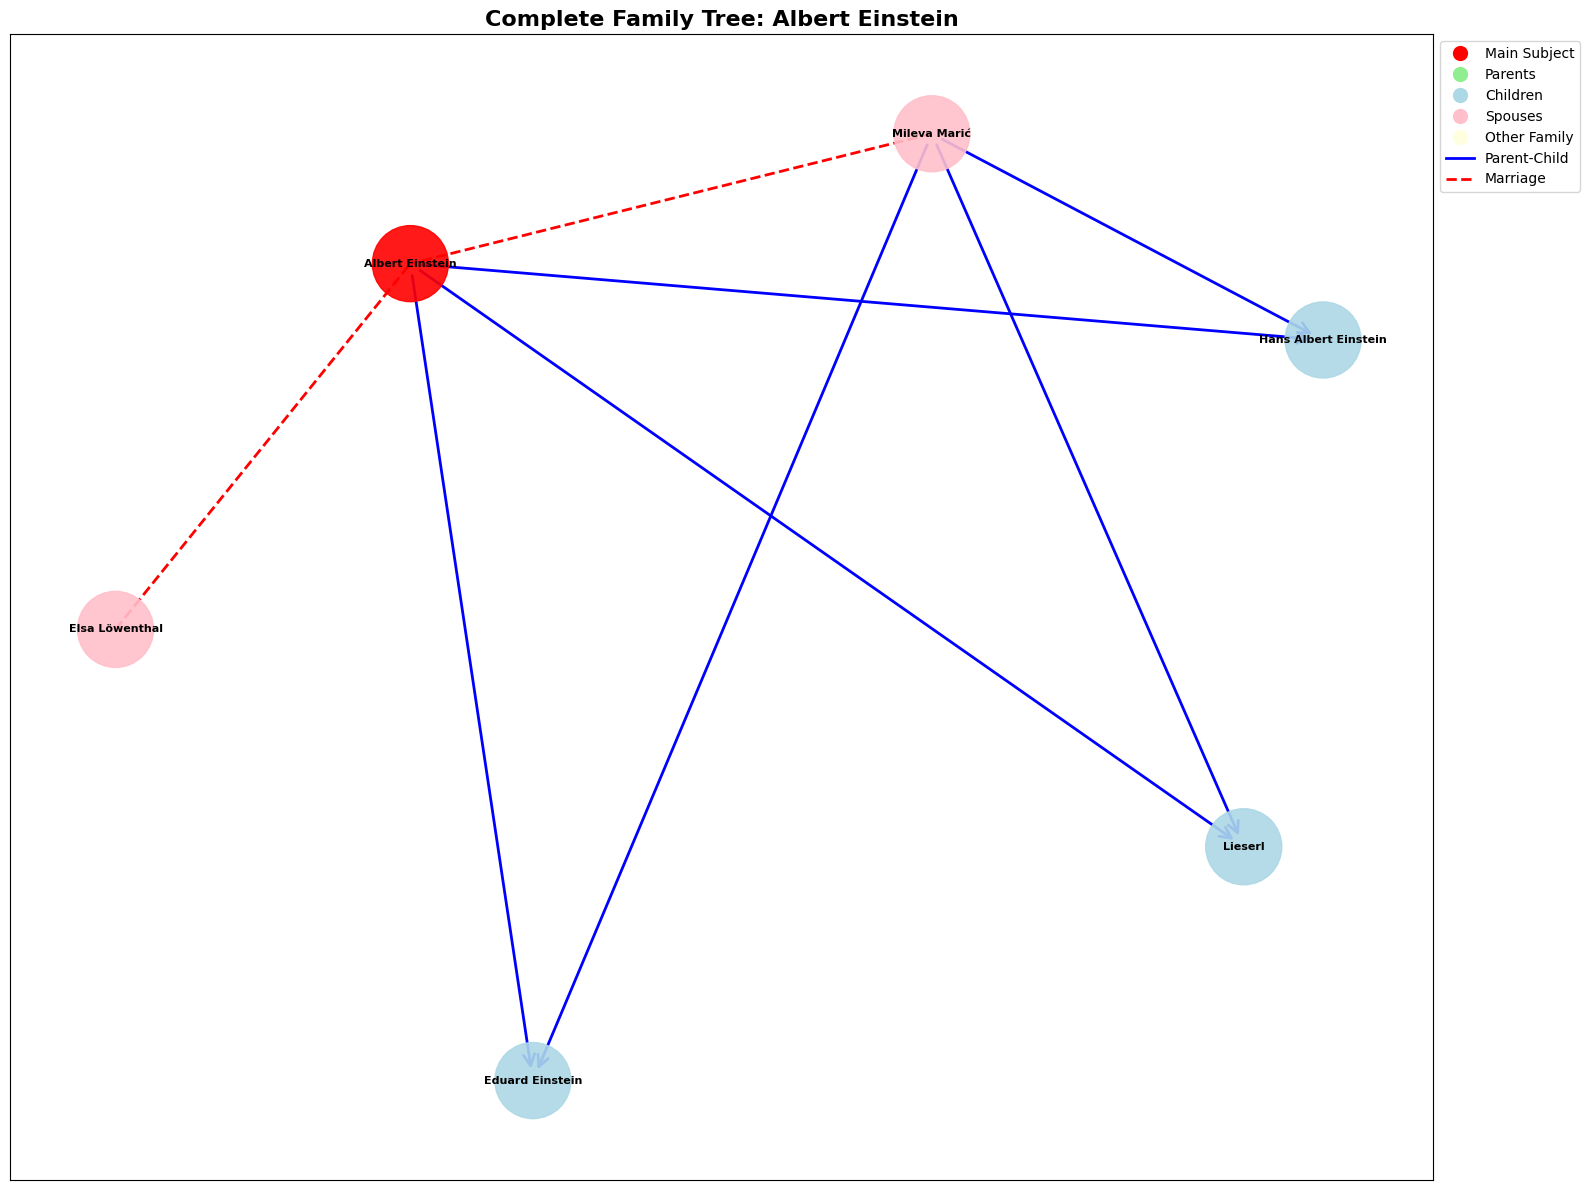

✅ Family tree visualization created!

🎉 Analysis complete! Found 6 family members.
🔗 Source: https://en.wikipedia.org/wiki/Albert_Einstein

RAW RELATIONSHIP STATEMENTS:
 1. Lieserl child of Mileva Marić
 2. Lieserl child of Albert Einstein
 3. Hans Albert Einstein child of Albert Einstein
 4. Hans Albert Einstein child of Mileva Marić
 5. Eduard Einstein child of Albert Einstein
 6. Eduard Einstein child of Mileva Marić
 7. Elsa Löwenthal spouse of Albert Einstein
 8. Mileva Marić spouse of Albert Einstein


In [4]:
#!/usr/bin/env python3
"""
Multi-Generational Genealogical Relationship Extractor for Wikipedia Articles
Extracts all family relationships across generations and formats as "child of" and "spouse of"
"""

# Install required packages
# !pip install wikipedia-api google-generativeai networkx matplotlib numpy

import wikipediaapi
import google.generativeai as genai
from google.generativeai import embed_content
import numpy as np
import re
from typing import List, Tuple, Dict, Optional, Set
import networkx as nx
import matplotlib.pyplot as plt
import time

# Configure Gemini API - Replace with your API key
GEMINI_API_KEY = "API key"
genai.configure(api_key=GEMINI_API_KEY)

def get_wikipedia_data(name: str, lang: str = "en") -> Dict:
    """
    Fetch Wikipedia page data and extract sections likely to contain genealogical info
    """
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent="GenealogyExtractor/1.0 (https://yourdomain.com)"
    )

    page = wiki.page(name)
    if not page.exists():
        return {"found": False, "query": name, "error": "Page not found"}

    # Keywords for sections likely to contain family/genealogical information
    genealogy_keywords = [
        "personal life", "family", "marriage", "children", "early life", "biography", "life",
        "relationships", "spouse", "wife", "husband", "descendants", "ancestry", "parents",
        "father", "mother", "siblings", "brother", "sister", "grandchildren", "grandparents",
        "birth", "childhood", "youth", "later life", "legacy", "death", "genealogy"
    ]

    def _find_section_by_keywords(sections: List[wikipediaapi.WikipediaPageSection],
                                 keywords: List[str]) -> List[wikipediaapi.WikipediaPageSection]:
        """Find sections containing genealogical keywords"""
        found_sections = []
        lower_keywords = [k.lower() for k in keywords]

        for section in sections:
            title_lower = (section.title or "").lower()
            if any(k in title_lower for k in lower_keywords):
                found_sections.append(section)
            # Recursively search subsections
            found_sections.extend(_find_section_by_keywords(section.sections, lower_keywords))

        return found_sections

    relevant_sections = _find_section_by_keywords(page.sections, genealogy_keywords)

    # Combine text from all relevant sections
    genealogy_text = ""
    section_titles = []

    for section in relevant_sections:
        if section.text.strip():
            genealogy_text += f"\n\n{section.title}:\n{section.text}"
            section_titles.append(section.title)

    # If no specific sections found, use summary and more of the main text
    if not genealogy_text.strip():
        genealogy_text = page.summary + "\n\n" + page.text[:5000]
        section_titles = ["Summary and Introduction"]
    else:
        # Also include summary for context
        genealogy_text = page.summary + "\n\n" + genealogy_text

    return {
        "found": True,
        "title": page.title,
        "url": page.fullurl,
        "summary": page.summary,
        "full_text": page.text,
        "genealogy_sections": section_titles,
        "genealogy_text": genealogy_text.strip(),
    }

def chunk_text_intelligently(text: str, max_chunk_size: int = 1500) -> List[str]:
    """
    Split text into larger chunks while preserving sentence and paragraph boundaries
    """
    # First split by paragraphs
    paragraphs = text.split('\n\n')
    chunks = []
    current_chunk = ""

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        # If adding this paragraph would exceed chunk size
        if len(current_chunk) + len(para) > max_chunk_size and current_chunk:
            chunks.append(current_chunk.strip())
            current_chunk = para
        else:
            if current_chunk:
                current_chunk += "\n\n" + para
            else:
                current_chunk = para

    # Add the last chunk
    if current_chunk.strip():
        chunks.append(current_chunk.strip())

    return chunks

def find_relevant_chunks_for_relationships(chunks: List[str], top_k: int = 5) -> List[Tuple[str, float]]:
    """
    Find chunks most relevant to genealogical relationships using embeddings
    """
    try:
        # More comprehensive relationship query
        relationship_query = """
        family relationships marriage spouse wife husband children son daughter parents father mother
        married divorced widowed offspring descendants lineage genealogy ancestry grandparents
        grandmother grandfather grandchildren grandson granddaughter siblings brother sister
        birth parentage family tree relatives kinship heredity generation bloodline
        """

        # Get embeddings for all chunks
        chunk_embeddings = []
        for chunk in chunks:
            try:
                emb = embed_content(model="models/embedding-001", content=chunk)["embedding"]
                chunk_embeddings.append(np.array(emb))
            except Exception as e:
                print(f"Error getting embedding for chunk: {e}")
                chunk_embeddings.append(np.zeros(768))  # Default embedding size

        # Get embedding for relationship query
        query_emb = embed_content(model="models/embedding-001", content=relationship_query)["embedding"]
        query_emb = np.array(query_emb)

        # Calculate similarities
        similarities = []
        for i, chunk_emb in enumerate(chunk_embeddings):
            if np.linalg.norm(chunk_emb) > 0 and np.linalg.norm(query_emb) > 0:
                similarity = np.dot(query_emb, chunk_emb) / (np.linalg.norm(query_emb) * np.linalg.norm(chunk_emb))
            else:
                similarity = 0
            similarities.append((chunks[i], similarity))

        # Sort by similarity and return top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

    except Exception as e:
        print(f"Error in similarity search: {e}")
        # Fallback: return chunks that contain relationship keywords
        relevant_chunks = []
        keywords = ["married", "wife", "husband", "spouse", "children", "son", "daughter",
                   "family", "father", "mother", "parents", "born", "grandfather", "grandmother"]
        for chunk in chunks:
            score = sum(1 for keyword in keywords if keyword.lower() in chunk.lower())
            if score > 0:
                relevant_chunks.append((chunk, score))

        relevant_chunks.sort(key=lambda x: x[1], reverse=True)
        return relevant_chunks[:top_k]

def extract_all_relationships_with_gemini(subject_name: str, relevant_text: str) -> List[str]:
    """
    Use Gemini to extract all family relationships across generations and format as "X child of Y" and "X spouse of Y"
    """
    prompt = f"""
You are a comprehensive genealogical relationship extractor. Extract ALL family relationships mentioned in the text about {subject_name} and their extended family across all generations.

IMPORTANT INSTRUCTIONS:
1. Extract ALL family relationships from the provided text - parents, grandparents, children, grandchildren, siblings, spouses, etc.
2. Format EVERY relationship as either "X child of Y" or "X spouse of Y"
3. Include relationships for ALL people mentioned, not just {subject_name}
4. Do NOT make assumptions - only extract what is explicitly stated in the text
5. Use full names when provided, otherwise use the names as given in the text

Text about {subject_name} and family:
{relevant_text}

Extract ALL relationships and format them as follows:
- For parent-child relationships: "[Child Name] child of [Parent Name]"
- For marriage relationships: "[Person1] spouse of [Person2]"

EXAMPLES of correct format:
- "Albert Einstein child of Hermann Einstein"
- "Albert Einstein child of Pauline Koch"
- "Albert Einstein spouse of Mileva Marić"
- "Hans Albert Einstein child of Albert Einstein"
- "Eduard Einstein child of Albert Einstein"
- "Mileva Marić spouse of Albert Einstein"

Return your answer as a simple list, one relationship per line, in this exact format:
[Person1] child of [Person2]
[Person1] spouse of [Person2]

Extract ALL relationships mentioned in the text for ALL family members across ALL generations.
Do not include any explanatory text, just the relationship statements.
"""

    try:
        model = genai.GenerativeModel('gemini-1.5-flash')
        response = model.generate_content(prompt)

        response_text = response.text.strip()

        # Parse relationships from response
        relationships = []
        lines = response_text.split('\n')

        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Remove any numbering or bullet points
            line = re.sub(r'^\d+\.\s*', '', line)
            line = re.sub(r'^-\s*', '', line)
            line = re.sub(r'^\*\s*', '', line)

            # Check if line contains "child of" or "spouse of"
            if " child of " in line.lower() or " spouse of " in line.lower():
                relationships.append(line)

        return relationships

    except Exception as e:
        print(f"Gemini API error: {e}")
        return []

def process_relationships(relationships: List[str]) -> Dict[str, List[Dict[str, str]]]:
    """
    Process and categorize the relationships
    """
    processed = {
        "child_of": [],
        "spouse_of": []
    }

    for rel in relationships:
        rel = rel.strip()
        if " child of " in rel.lower():
            parts = rel.split(" child of ")
            if len(parts) == 2:
                child = parts[0].strip()
                parent = parts[1].strip()
                processed["child_of"].append({
                    "child": child,
                    "parent": parent,
                    "relationship": f"{child} child of {parent}"
                })

        elif " spouse of " in rel.lower():
            parts = re.split(r" spouse of ", rel, flags=re.IGNORECASE)
            if len(parts) == 2:
                spouse1 = parts[0].strip()
                spouse2 = parts[1].strip()
                processed["spouse_of"].append({
                    "spouse1": spouse1,
                    "spouse2": spouse2,
                    "relationship": f"{spouse1} spouse of {spouse2}"
                })

    return processed

def create_comprehensive_family_graph(relationships: Dict[str, List[Dict[str, str]]]) -> nx.DiGraph:
    """
    Create a comprehensive family tree graph with all relationships
    """
    G = nx.DiGraph()

    # Add all people as nodes first
    all_people = set()

    # Collect all unique people mentioned
    for child_rel in relationships["child_of"]:
        all_people.add(child_rel["child"])
        all_people.add(child_rel["parent"])

    for spouse_rel in relationships["spouse_of"]:
        all_people.add(spouse_rel["spouse1"])
        all_people.add(spouse_rel["spouse2"])

    # Add nodes
    for person in all_people:
        G.add_node(person)

    # Add parent-child edges (directed)
    for child_rel in relationships["child_of"]:
        G.add_edge(child_rel["parent"], child_rel["child"],
                  relationship="parent_of",
                  label="parent of")

    # Add spouse edges (undirected in nature, but we'll add both directions)
    for spouse_rel in relationships["spouse_of"]:
        G.add_edge(spouse_rel["spouse1"], spouse_rel["spouse2"],
                  relationship="spouse_of",
                  label="spouse of")

    return G

def visualize_comprehensive_family_tree(G: nx.DiGraph, subject_name: str, relationships: Dict):
    """
    Visualize the comprehensive family tree
    """
    plt.figure(figsize=(16, 12))

    # Use hierarchical layout for better family tree visualization
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    except:
        # Fallback to spring layout if graphviz not available
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

    # Define colors for different node types
    node_colors = []
    for node in G.nodes():
        if node.lower() == subject_name.lower():
            node_colors.append('red')
        else:
            # Check if this person is a parent, child, or spouse of subject
            is_parent = any(rel["parent"].lower() == node.lower() and
                           rel["child"].lower() == subject_name.lower()
                           for rel in relationships["child_of"])
            is_child = any(rel["child"].lower() == node.lower() and
                          rel["parent"].lower() == subject_name.lower()
                          for rel in relationships["child_of"])
            is_spouse = any((rel["spouse1"].lower() == node.lower() and
                            rel["spouse2"].lower() == subject_name.lower()) or
                           (rel["spouse2"].lower() == node.lower() and
                            rel["spouse1"].lower() == subject_name.lower())
                           for rel in relationships["spouse_of"])

            if is_parent:
                node_colors.append('lightgreen')
            elif is_child:
                node_colors.append('lightblue')
            elif is_spouse:
                node_colors.append('pink')
            else:
                node_colors.append('lightyellow')

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=3000, alpha=0.9)

    # Draw edges with different styles for different relationships
    parent_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('relationship') == 'parent_of']
    spouse_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('relationship') == 'spouse_of']

    nx.draw_networkx_edges(G, pos, edgelist=parent_edges,
                          edge_color='blue', arrows=True, arrowsize=20,
                          arrowstyle='->', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=spouse_edges,
                          edge_color='red', arrows=False, width=2, style='dashed')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title(f"Complete Family Tree: {subject_name}", fontsize=16, fontweight='bold')

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                  markersize=12, label='Main Subject'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen',
                  markersize=12, label='Parents'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                  markersize=12, label='Children'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink',
                  markersize=12, label='Spouses'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightyellow',
                  markersize=12, label='Other Family'),
        plt.Line2D([0], [0], color='blue', linewidth=2, label='Parent-Child'),
        plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Marriage')
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

def print_relationship_summary(relationships: Dict[str, List[Dict[str, str]]], subject_name: str):
    """
    Print a comprehensive summary of all relationships
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE GENEALOGICAL RELATIONSHIPS")
    print("="*80)

    print(f"\n🎯 Main Subject: {subject_name}")

    # Child of relationships
    if relationships["child_of"]:
        print(f"\n👨‍👩‍👧‍👦 PARENT-CHILD RELATIONSHIPS ({len(relationships['child_of'])}):")
        print("-" * 60)
        for i, rel in enumerate(relationships["child_of"], 1):
            print(f"{i:2d}. {rel['relationship']}")
    else:
        print(f"\n👨‍👩‍👧‍👦 PARENT-CHILD RELATIONSHIPS: None found")

    # Spouse relationships
    if relationships["spouse_of"]:
        print(f"\n💑 MARRIAGE RELATIONSHIPS ({len(relationships['spouse_of'])}):")
        print("-" * 60)
        for i, rel in enumerate(relationships["spouse_of"], 1):
            print(f"{i:2d}. {rel['relationship']}")
    else:
        print(f"\n💑 MARRIAGE RELATIONSHIPS: None found")

    # Generate statistics
    all_people = set()
    for rel in relationships["child_of"]:
        all_people.add(rel["child"])
        all_people.add(rel["parent"])
    for rel in relationships["spouse_of"]:
        all_people.add(rel["spouse1"])
        all_people.add(rel["spouse2"])

    print(f"\n📊 STATISTICS:")
    print(f"   • Total people mentioned: {len(all_people)}")
    print(f"   • Parent-child relationships: {len(relationships['child_of'])}")
    print(f"   • Marriage relationships: {len(relationships['spouse_of'])}")
    print(f"   • Total relationships: {len(relationships['child_of']) + len(relationships['spouse_of'])}")

def extract_comprehensive_genealogy(person_name: str):
    """
    Main function to extract comprehensive genealogical relationships across all generations
    """
    print(f"🧬 COMPREHENSIVE GENEALOGY EXTRACTOR")
    print("="*80)
    print(f"Analyzing: {person_name}")
    print("="*80)

    # Step 1: Get Wikipedia data
    print("Step 1: Fetching Wikipedia data...")
    wiki_data = get_wikipedia_data(person_name)

    if not wiki_data.get("found"):
        print(f"❌ Error: {wiki_data.get('error', 'Unknown error')}")
        return None

    print(f"✅ Found Wikipedia page: {wiki_data['title']}")
    print(f"✅ Relevant sections: {', '.join(wiki_data['genealogy_sections'])}")
    print(f"✅ Text length: {len(wiki_data['genealogy_text'])} characters")

    # Step 2: Chunk the text
    print("\nStep 2: Chunking text for analysis...")
    chunks = chunk_text_intelligently(wiki_data['genealogy_text'])
    print(f"✅ Created {len(chunks)} text chunks")

    # Step 3: Find most relevant chunks
    print("\nStep 3: Finding most relevant chunks...")
    try:
        relevant_chunks = find_relevant_chunks_for_relationships(chunks, top_k=5)
        print(f"✅ Selected top {len(relevant_chunks)} relevant chunks")

        # Combine all relevant chunks for comprehensive analysis
        combined_text = "\n\n---CHUNK SEPARATOR---\n\n".join([chunk for chunk, score in relevant_chunks])
    except Exception as e:
        print(f"⚠️ Embedding search failed ({e}), using full text")
        combined_text = wiki_data['genealogy_text']

    # Step 4: Extract comprehensive relationships
    print("\nStep 4: Extracting all relationships with Gemini...")
    print("   (This may take a moment for comprehensive analysis...)")

    all_relationships = extract_all_relationships_with_gemini(wiki_data['title'], combined_text)

    if not all_relationships:
        print("❌ No relationships extracted")
        return None

    print(f"✅ Extracted {len(all_relationships)} relationship statements")

    # Step 5: Process relationships
    print("\nStep 5: Processing and categorizing relationships...")
    processed_relationships = process_relationships(all_relationships)

    # Step 6: Display results
    print_relationship_summary(processed_relationships, wiki_data['title'])

    # Step 7: Create and visualize family tree
    print(f"\nStep 6: Creating comprehensive family tree visualization...")
    family_graph = create_comprehensive_family_graph(processed_relationships)

    if len(family_graph.nodes()) > 0:
        visualize_comprehensive_family_tree(family_graph, wiki_data['title'], processed_relationships)
        print("✅ Family tree visualization created!")
    else:
        print("⚠️ No relationships to visualize")

    # Return comprehensive results
    result = {
        'subject': wiki_data['title'],
        'all_relationship_statements': all_relationships,
        'processed_relationships': processed_relationships,
        'family_graph': family_graph,
        'source_url': wiki_data['url'],
        'total_people': len(set().union(
            {rel["child"] for rel in processed_relationships["child_of"]},
            {rel["parent"] for rel in processed_relationships["child_of"]},
            {rel["spouse1"] for rel in processed_relationships["spouse_of"]},
            {rel["spouse2"] for rel in processed_relationships["spouse_of"]}
        ))
    }

    print(f"\n🎉 Analysis complete! Found {result['total_people']} family members.")
    print(f"🔗 Source: {result['source_url']}")

    return result

# Example usage and testing
if __name__ == "__main__":
    print("🧬 COMPREHENSIVE GENEALOGICAL RELATIONSHIP EXTRACTOR")
    print("="*80)
    print("Extracts multi-generational family relationships from Wikipedia")
    print("Format: 'Person child of Parent' and 'Person spouse of Spouse'")
    print("="*80)

    # Example usage:
    # result = extract_comprehensive_genealogy("Albert Einstein")
    # result = extract_comprehensive_genealogy("Charles II of England")
    # result = extract_comprehensive_genealogy("Queen Victoria")

    # Interactive mode
    person_name = input("\nEnter the name of a person to analyze: ").strip()
    if person_name:
        result = extract_comprehensive_genealogy(person_name)

        if result:
            print(f"\n" + "="*50)
            print("RAW RELATIONSHIP STATEMENTS:")
            print("="*50)
            for i, rel in enumerate(result['all_relationship_statements'], 1):
                print(f"{i:2d}. {rel}")

    else:
        print("Please provide a person's name to analyze.")

🧬 COMPREHENSIVE GENEALOGICAL RELATIONSHIP EXTRACTOR
Extracts multi-generational family relationships from Wikipedia
Format: 'Person child of Parent' and 'Person spouse of Spouse'

Enter the name of a person to analyze: Charles III
🧬 COMPREHENSIVE GENEALOGY EXTRACTOR
Analyzing: Charles III
Step 1: Fetching Wikipedia data...
✅ Found Wikipedia page: Charles III
✅ Relevant sections: Early life, family, and education
✅ Text length: 6212 characters

Step 2: Chunking text for analysis...
✅ Created 4 text chunks

Step 3: Finding most relevant chunks...
✅ Selected top 4 relevant chunks

Step 4: Extracting all relationships with Gemini...
   (This may take a moment for comprehensive analysis...)
✅ Extracted 16 relationship statements

Step 5: Processing and categorizing relationships...

COMPREHENSIVE GENEALOGICAL RELATIONSHIPS

🎯 Main Subject: Charles III

👨‍👩‍👧‍👦 PARENT-CHILD RELATIONSHIPS (14):
------------------------------------------------------------
 1. Charles III child of Princess Eliz

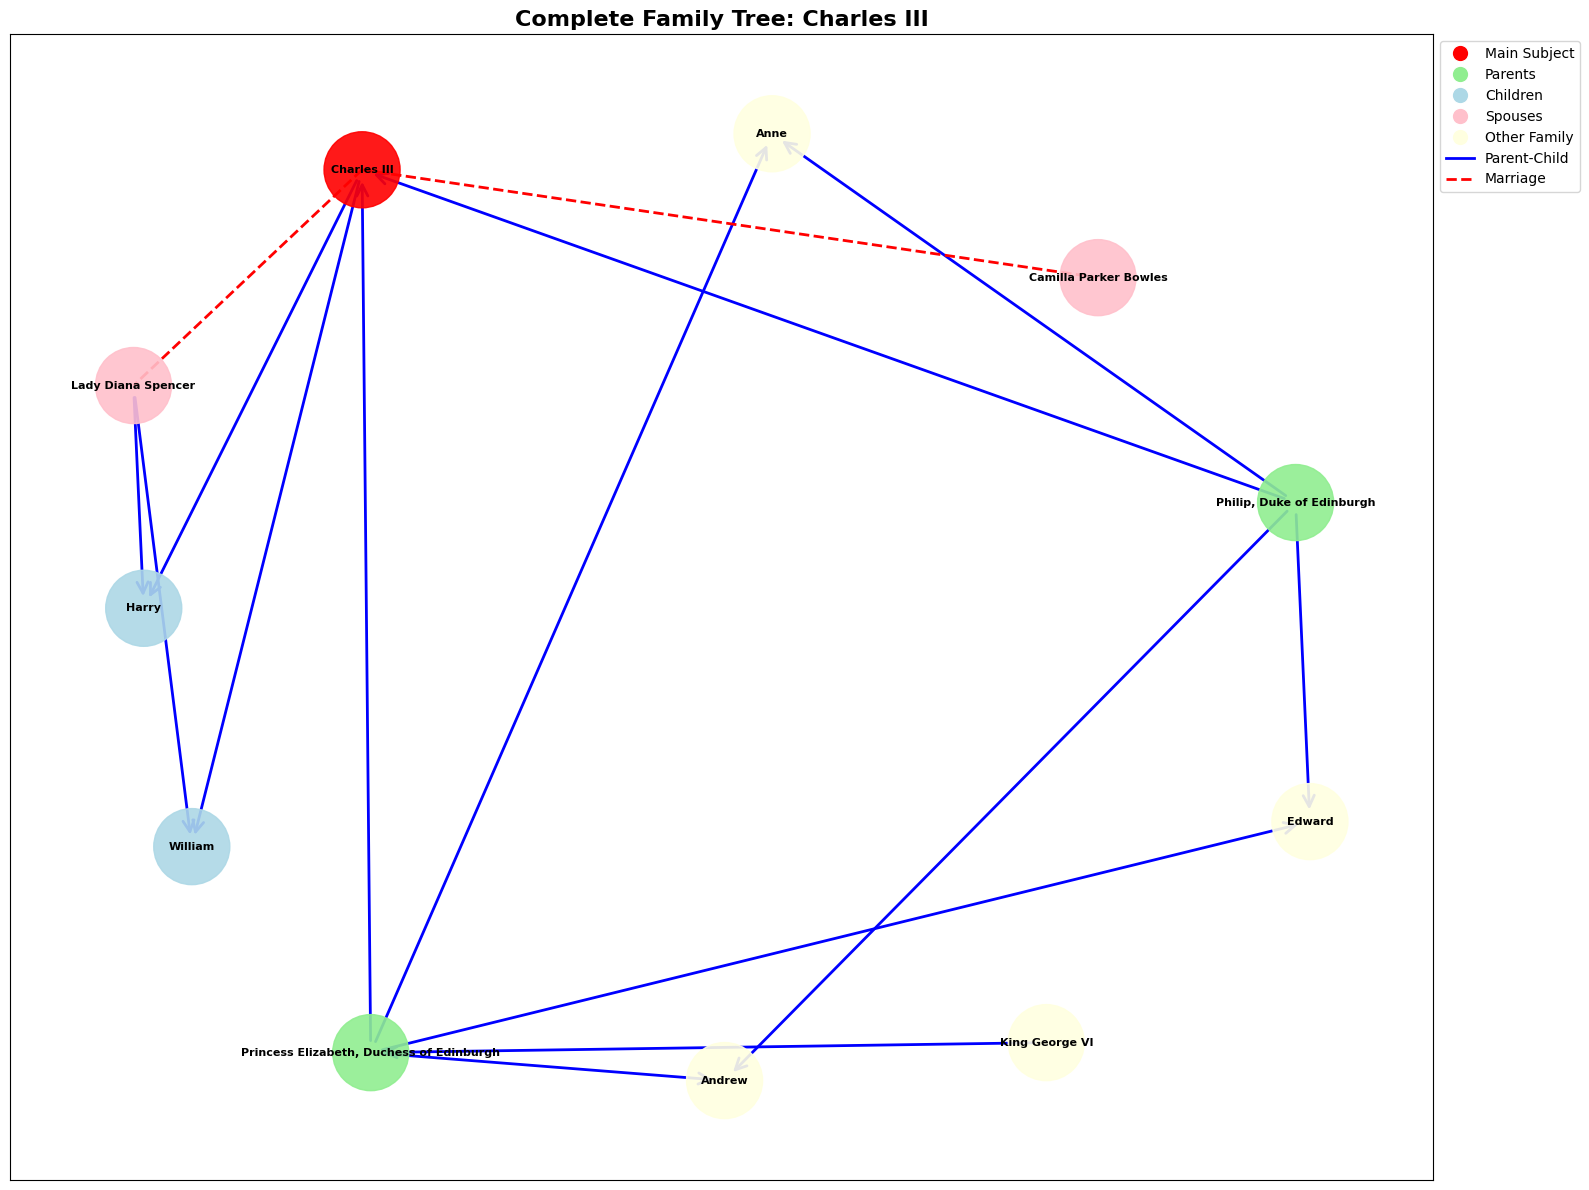

✅ Family tree visualization created!

🎉 Analysis complete! Found 11 family members.
🔗 Source: https://en.wikipedia.org/wiki/Charles_III

RAW RELATIONSHIP STATEMENTS:
 1. Charles III child of Princess Elizabeth, Duchess of Edinburgh
 2. Charles III child of Philip, Duke of Edinburgh
 3. Anne child of Princess Elizabeth, Duchess of Edinburgh
 4. Anne child of Philip, Duke of Edinburgh
 5. Andrew child of Princess Elizabeth, Duchess of Edinburgh
 6. Andrew child of Philip, Duke of Edinburgh
 7. Edward child of Princess Elizabeth, Duchess of Edinburgh
 8. Edward child of Philip, Duke of Edinburgh
 9. Charles III spouse of Lady Diana Spencer
10. William child of Charles III
11. William child of Lady Diana Spencer
12. Harry child of Charles III
13. Harry child of Lady Diana Spencer
14. Charles III spouse of Camilla Parker Bowles
15. Princess Elizabeth, Duchess of Edinburgh child of King George VI
16. Charles III child of Princess Elizabeth, Duchess of Edinburgh


In [5]:
#!/usr/bin/env python3
"""
Multi-Generational Genealogical Relationship Extractor for Wikipedia Articles
Extracts all family relationships across generations and formats as "child of" and "spouse of"
"""

# Install required packages
# !pip install wikipedia-api google-generativeai networkx matplotlib numpy

import wikipediaapi
import google.generativeai as genai
from google.generativeai import embed_content
import numpy as np
import re
from typing import List, Tuple, Dict, Optional, Set
import networkx as nx
import matplotlib.pyplot as plt
import time

# Configure Gemini API - Replace with your API key
GEMINI_API_KEY = "API key"
genai.configure(api_key=GEMINI_API_KEY)

def get_wikipedia_data(name: str, lang: str = "en") -> Dict:
    """
    Fetch Wikipedia page data and extract sections likely to contain genealogical info
    """
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent="GenealogyExtractor/1.0 (https://yourdomain.com)"
    )

    page = wiki.page(name)
    if not page.exists():
        return {"found": False, "query": name, "error": "Page not found"}

    # Keywords for sections likely to contain family/genealogical information
    genealogy_keywords = [
        "personal life", "family", "marriage", "children", "early life", "biography", "life",
        "relationships", "spouse", "wife", "husband", "descendants", "ancestry", "parents",
        "father", "mother", "siblings", "brother", "sister", "grandchildren", "grandparents",
        "birth", "childhood", "youth", "later life", "legacy", "death", "genealogy"
    ]

    def _find_section_by_keywords(sections: List[wikipediaapi.WikipediaPageSection],
                                 keywords: List[str]) -> List[wikipediaapi.WikipediaPageSection]:
        """Find sections containing genealogical keywords"""
        found_sections = []
        lower_keywords = [k.lower() for k in keywords]

        for section in sections:
            title_lower = (section.title or "").lower()
            if any(k in title_lower for k in lower_keywords):
                found_sections.append(section)
            # Recursively search subsections
            found_sections.extend(_find_section_by_keywords(section.sections, lower_keywords))

        return found_sections

    relevant_sections = _find_section_by_keywords(page.sections, genealogy_keywords)

    # Combine text from all relevant sections
    genealogy_text = ""
    section_titles = []

    for section in relevant_sections:
        if section.text.strip():
            genealogy_text += f"\n\n{section.title}:\n{section.text}"
            section_titles.append(section.title)

    # If no specific sections found, use summary and more of the main text
    if not genealogy_text.strip():
        genealogy_text = page.summary + "\n\n" + page.text[:5000]
        section_titles = ["Summary and Introduction"]
    else:
        # Also include summary for context
        genealogy_text = page.summary + "\n\n" + genealogy_text

    return {
        "found": True,
        "title": page.title,
        "url": page.fullurl,
        "summary": page.summary,
        "full_text": page.text,
        "genealogy_sections": section_titles,
        "genealogy_text": genealogy_text.strip(),
    }

def chunk_text_intelligently(text: str, max_chunk_size: int = 1500) -> List[str]:
    """
    Split text into larger chunks while preserving sentence and paragraph boundaries
    """
    # First split by paragraphs
    paragraphs = text.split('\n\n')
    chunks = []
    current_chunk = ""

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        # If adding this paragraph would exceed chunk size
        if len(current_chunk) + len(para) > max_chunk_size and current_chunk:
            chunks.append(current_chunk.strip())
            current_chunk = para
        else:
            if current_chunk:
                current_chunk += "\n\n" + para
            else:
                current_chunk = para

    # Add the last chunk
    if current_chunk.strip():
        chunks.append(current_chunk.strip())

    return chunks

def find_relevant_chunks_for_relationships(chunks: List[str], top_k: int = 5) -> List[Tuple[str, float]]:
    """
    Find chunks most relevant to genealogical relationships using embeddings
    """
    try:
        # More comprehensive relationship query
        relationship_query = """
        family relationships marriage spouse wife husband children son daughter parents father mother
        married divorced widowed offspring descendants lineage genealogy ancestry grandparents
        grandmother grandfather grandchildren grandson granddaughter siblings brother sister
        birth parentage family tree relatives kinship heredity generation bloodline
        """

        # Get embeddings for all chunks
        chunk_embeddings = []
        for chunk in chunks:
            try:
                emb = embed_content(model="models/embedding-001", content=chunk)["embedding"]
                chunk_embeddings.append(np.array(emb))
            except Exception as e:
                print(f"Error getting embedding for chunk: {e}")
                chunk_embeddings.append(np.zeros(768))  # Default embedding size

        # Get embedding for relationship query
        query_emb = embed_content(model="models/embedding-001", content=relationship_query)["embedding"]
        query_emb = np.array(query_emb)

        # Calculate similarities
        similarities = []
        for i, chunk_emb in enumerate(chunk_embeddings):
            if np.linalg.norm(chunk_emb) > 0 and np.linalg.norm(query_emb) > 0:
                similarity = np.dot(query_emb, chunk_emb) / (np.linalg.norm(query_emb) * np.linalg.norm(chunk_emb))
            else:
                similarity = 0
            similarities.append((chunks[i], similarity))

        # Sort by similarity and return top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

    except Exception as e:
        print(f"Error in similarity search: {e}")
        # Fallback: return chunks that contain relationship keywords
        relevant_chunks = []
        keywords = ["married", "wife", "husband", "spouse", "children", "son", "daughter",
                   "family", "father", "mother", "parents", "born", "grandfather", "grandmother"]
        for chunk in chunks:
            score = sum(1 for keyword in keywords if keyword.lower() in chunk.lower())
            if score > 0:
                relevant_chunks.append((chunk, score))

        relevant_chunks.sort(key=lambda x: x[1], reverse=True)
        return relevant_chunks[:top_k]

def extract_all_relationships_with_gemini(subject_name: str, relevant_text: str) -> List[str]:
    """
    Use Gemini to extract all family relationships across generations and format as "X child of Y" and "X spouse of Y"
    """
    prompt = f"""
You are a comprehensive genealogical relationship extractor. Extract ALL family relationships mentioned in the text about {subject_name} and their extended family across all generations.

IMPORTANT INSTRUCTIONS:
1. Extract ALL family relationships from the provided text - parents, grandparents, children, grandchildren, siblings, spouses, etc.
2. Format EVERY relationship as either "X child of Y" or "X spouse of Y"
3. Include relationships for ALL people mentioned, not just {subject_name}
4. Do NOT make assumptions - only extract what is explicitly stated in the text
5. Use full names when provided, otherwise use the names as given in the text

Text about {subject_name} and family:
{relevant_text}

Extract ALL relationships and format them as follows:
- For parent-child relationships: "[Child Name] child of [Parent Name]"
- For marriage relationships: "[Person1] spouse of [Person2]"

EXAMPLES of correct format:
- "Albert Einstein child of Hermann Einstein"
- "Albert Einstein child of Pauline Koch"
- "Albert Einstein spouse of Mileva Marić"
- "Hans Albert Einstein child of Albert Einstein"
- "Eduard Einstein child of Albert Einstein"
- "Mileva Marić spouse of Albert Einstein"

Return your answer as a simple list, one relationship per line, in this exact format:
[Person1] child of [Person2]
[Person1] spouse of [Person2]

Extract ALL relationships mentioned in the text for ALL family members across ALL generations.
Do not include any explanatory text, just the relationship statements.
"""

    try:
        model = genai.GenerativeModel('gemini-1.5-flash')
        response = model.generate_content(prompt)

        response_text = response.text.strip()

        # Parse relationships from response
        relationships = []
        lines = response_text.split('\n')

        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Remove any numbering or bullet points
            line = re.sub(r'^\d+\.\s*', '', line)
            line = re.sub(r'^-\s*', '', line)
            line = re.sub(r'^\*\s*', '', line)

            # Check if line contains "child of" or "spouse of"
            if " child of " in line.lower() or " spouse of " in line.lower():
                relationships.append(line)

        return relationships

    except Exception as e:
        print(f"Gemini API error: {e}")
        return []

def process_relationships(relationships: List[str]) -> Dict[str, List[Dict[str, str]]]:
    """
    Process and categorize the relationships
    """
    processed = {
        "child_of": [],
        "spouse_of": []
    }

    for rel in relationships:
        rel = rel.strip()
        if " child of " in rel.lower():
            parts = rel.split(" child of ")
            if len(parts) == 2:
                child = parts[0].strip()
                parent = parts[1].strip()
                processed["child_of"].append({
                    "child": child,
                    "parent": parent,
                    "relationship": f"{child} child of {parent}"
                })

        elif " spouse of " in rel.lower():
            parts = re.split(r" spouse of ", rel, flags=re.IGNORECASE)
            if len(parts) == 2:
                spouse1 = parts[0].strip()
                spouse2 = parts[1].strip()
                processed["spouse_of"].append({
                    "spouse1": spouse1,
                    "spouse2": spouse2,
                    "relationship": f"{spouse1} spouse of {spouse2}"
                })

    return processed

def create_comprehensive_family_graph(relationships: Dict[str, List[Dict[str, str]]]) -> nx.DiGraph:
    """
    Create a comprehensive family tree graph with all relationships
    """
    G = nx.DiGraph()

    # Add all people as nodes first
    all_people = set()

    # Collect all unique people mentioned
    for child_rel in relationships["child_of"]:
        all_people.add(child_rel["child"])
        all_people.add(child_rel["parent"])

    for spouse_rel in relationships["spouse_of"]:
        all_people.add(spouse_rel["spouse1"])
        all_people.add(spouse_rel["spouse2"])

    # Add nodes
    for person in all_people:
        G.add_node(person)

    # Add parent-child edges (directed)
    for child_rel in relationships["child_of"]:
        G.add_edge(child_rel["parent"], child_rel["child"],
                  relationship="parent_of",
                  label="parent of")

    # Add spouse edges (undirected in nature, but we'll add both directions)
    for spouse_rel in relationships["spouse_of"]:
        G.add_edge(spouse_rel["spouse1"], spouse_rel["spouse2"],
                  relationship="spouse_of",
                  label="spouse of")

    return G

def visualize_comprehensive_family_tree(G: nx.DiGraph, subject_name: str, relationships: Dict):
    """
    Visualize the comprehensive family tree
    """
    plt.figure(figsize=(16, 12))

    # Use hierarchical layout for better family tree visualization
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    except:
        # Fallback to spring layout if graphviz not available
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

    # Define colors for different node types
    node_colors = []
    for node in G.nodes():
        if node.lower() == subject_name.lower():
            node_colors.append('red')
        else:
            # Check if this person is a parent, child, or spouse of subject
            is_parent = any(rel["parent"].lower() == node.lower() and
                           rel["child"].lower() == subject_name.lower()
                           for rel in relationships["child_of"])
            is_child = any(rel["child"].lower() == node.lower() and
                          rel["parent"].lower() == subject_name.lower()
                          for rel in relationships["child_of"])
            is_spouse = any((rel["spouse1"].lower() == node.lower() and
                            rel["spouse2"].lower() == subject_name.lower()) or
                           (rel["spouse2"].lower() == node.lower() and
                            rel["spouse1"].lower() == subject_name.lower())
                           for rel in relationships["spouse_of"])

            if is_parent:
                node_colors.append('lightgreen')
            elif is_child:
                node_colors.append('lightblue')
            elif is_spouse:
                node_colors.append('pink')
            else:
                node_colors.append('lightyellow')

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=3000, alpha=0.9)

    # Draw edges with different styles for different relationships
    parent_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('relationship') == 'parent_of']
    spouse_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('relationship') == 'spouse_of']

    nx.draw_networkx_edges(G, pos, edgelist=parent_edges,
                          edge_color='blue', arrows=True, arrowsize=20,
                          arrowstyle='->', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=spouse_edges,
                          edge_color='red', arrows=False, width=2, style='dashed')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title(f"Complete Family Tree: {subject_name}", fontsize=16, fontweight='bold')

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                  markersize=12, label='Main Subject'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen',
                  markersize=12, label='Parents'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                  markersize=12, label='Children'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink',
                  markersize=12, label='Spouses'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightyellow',
                  markersize=12, label='Other Family'),
        plt.Line2D([0], [0], color='blue', linewidth=2, label='Parent-Child'),
        plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Marriage')
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

def print_relationship_summary(relationships: Dict[str, List[Dict[str, str]]], subject_name: str):
    """
    Print a comprehensive summary of all relationships
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE GENEALOGICAL RELATIONSHIPS")
    print("="*80)

    print(f"\n🎯 Main Subject: {subject_name}")

    # Child of relationships
    if relationships["child_of"]:
        print(f"\n👨‍👩‍👧‍👦 PARENT-CHILD RELATIONSHIPS ({len(relationships['child_of'])}):")
        print("-" * 60)
        for i, rel in enumerate(relationships["child_of"], 1):
            print(f"{i:2d}. {rel['relationship']}")
    else:
        print(f"\n👨‍👩‍👧‍👦 PARENT-CHILD RELATIONSHIPS: None found")

    # Spouse relationships
    if relationships["spouse_of"]:
        print(f"\n💑 MARRIAGE RELATIONSHIPS ({len(relationships['spouse_of'])}):")
        print("-" * 60)
        for i, rel in enumerate(relationships["spouse_of"], 1):
            print(f"{i:2d}. {rel['relationship']}")
    else:
        print(f"\n💑 MARRIAGE RELATIONSHIPS: None found")

    # Generate statistics
    all_people = set()
    for rel in relationships["child_of"]:
        all_people.add(rel["child"])
        all_people.add(rel["parent"])
    for rel in relationships["spouse_of"]:
        all_people.add(rel["spouse1"])
        all_people.add(rel["spouse2"])

    print(f"\n📊 STATISTICS:")
    print(f"   • Total people mentioned: {len(all_people)}")
    print(f"   • Parent-child relationships: {len(relationships['child_of'])}")
    print(f"   • Marriage relationships: {len(relationships['spouse_of'])}")
    print(f"   • Total relationships: {len(relationships['child_of']) + len(relationships['spouse_of'])}")

def extract_comprehensive_genealogy(person_name: str):
    """
    Main function to extract comprehensive genealogical relationships across all generations
    """
    print(f"🧬 COMPREHENSIVE GENEALOGY EXTRACTOR")
    print("="*80)
    print(f"Analyzing: {person_name}")
    print("="*80)

    # Step 1: Get Wikipedia data
    print("Step 1: Fetching Wikipedia data...")
    wiki_data = get_wikipedia_data(person_name)

    if not wiki_data.get("found"):
        print(f"❌ Error: {wiki_data.get('error', 'Unknown error')}")
        return None

    print(f"✅ Found Wikipedia page: {wiki_data['title']}")
    print(f"✅ Relevant sections: {', '.join(wiki_data['genealogy_sections'])}")
    print(f"✅ Text length: {len(wiki_data['genealogy_text'])} characters")

    # Step 2: Chunk the text
    print("\nStep 2: Chunking text for analysis...")
    chunks = chunk_text_intelligently(wiki_data['genealogy_text'])
    print(f"✅ Created {len(chunks)} text chunks")

    # Step 3: Find most relevant chunks
    print("\nStep 3: Finding most relevant chunks...")
    try:
        relevant_chunks = find_relevant_chunks_for_relationships(chunks, top_k=5)
        print(f"✅ Selected top {len(relevant_chunks)} relevant chunks")

        # Combine all relevant chunks for comprehensive analysis
        combined_text = "\n\n---CHUNK SEPARATOR---\n\n".join([chunk for chunk, score in relevant_chunks])
    except Exception as e:
        print(f"⚠️ Embedding search failed ({e}), using full text")
        combined_text = wiki_data['genealogy_text']

    # Step 4: Extract comprehensive relationships
    print("\nStep 4: Extracting all relationships with Gemini...")
    print("   (This may take a moment for comprehensive analysis...)")

    all_relationships = extract_all_relationships_with_gemini(wiki_data['title'], combined_text)

    if not all_relationships:
        print("❌ No relationships extracted")
        return None

    print(f"✅ Extracted {len(all_relationships)} relationship statements")

    # Step 5: Process relationships
    print("\nStep 5: Processing and categorizing relationships...")
    processed_relationships = process_relationships(all_relationships)

    # Step 6: Display results
    print_relationship_summary(processed_relationships, wiki_data['title'])

    # Step 7: Create and visualize family tree
    print(f"\nStep 6: Creating comprehensive family tree visualization...")
    family_graph = create_comprehensive_family_graph(processed_relationships)

    if len(family_graph.nodes()) > 0:
        visualize_comprehensive_family_tree(family_graph, wiki_data['title'], processed_relationships)
        print("✅ Family tree visualization created!")
    else:
        print("⚠️ No relationships to visualize")

    # Return comprehensive results
    result = {
        'subject': wiki_data['title'],
        'all_relationship_statements': all_relationships,
        'processed_relationships': processed_relationships,
        'family_graph': family_graph,
        'source_url': wiki_data['url'],
        'total_people': len(set().union(
            {rel["child"] for rel in processed_relationships["child_of"]},
            {rel["parent"] for rel in processed_relationships["child_of"]},
            {rel["spouse1"] for rel in processed_relationships["spouse_of"]},
            {rel["spouse2"] for rel in processed_relationships["spouse_of"]}
        ))
    }

    print(f"\n🎉 Analysis complete! Found {result['total_people']} family members.")
    print(f"🔗 Source: {result['source_url']}")

    return result

# Example usage and testing
if __name__ == "__main__":
    print("🧬 COMPREHENSIVE GENEALOGICAL RELATIONSHIP EXTRACTOR")
    print("="*80)
    print("Extracts multi-generational family relationships from Wikipedia")
    print("Format: 'Person child of Parent' and 'Person spouse of Spouse'")
    print("="*80)

    # Example usage:
    # result = extract_comprehensive_genealogy("Albert Einstein")
    # result = extract_comprehensive_genealogy("Charles II of England")
    # result = extract_comprehensive_genealogy("Queen Victoria")

    # Interactive mode
    person_name = input("\nEnter the name of a person to analyze: ").strip()
    if person_name:
        result = extract_comprehensive_genealogy(person_name)

        if result:
            print(f"\n" + "="*50)
            print("RAW RELATIONSHIP STATEMENTS:")
            print("="*50)
            for i, rel in enumerate(result['all_relationship_statements'], 1):
                print(f"{i:2d}. {rel}")

    else:
        print("Please provide a person's name to analyze.")